# Context

This analysis tests whether deep learning can outperform traditional linear models for Home Credit's default prediction. The workflow follows this specific structure:

1.  **Feature Engineering:** First, we construct domain-specific features (composite scores and financial ratios) to capture borrower risk more effectively than raw data alone.
2.  **Linear Benchmark (Phase 1):** We quantify the value of these new features by comparing a "Raw Data" Logistic Regression against an "Engineered" Logistic Regression.
3.  **Non-Linear Experiment (Phase 2):** We then deploy Neural Networks on the engineered feature set to see if non-linear architectures can extract even more signal (or if they fail due to data complexity).

The workflow utilizes a Python environment to leverage multi-core CPU optimization for rapid iteration.

In [1]:
import os

n_cores = os.cpu_count() or 1

os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyprojroot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

SEED = 1234
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_COLS = {
    'teal': "#00534B",
    'orange': "#F05627",
    'purple': "#523348",
    'skyblue': "#A9C0CB"
}

print(f"System initialized: Optimized for {n_cores} physical cores")

System initialized: Optimized for 24 physical cores


# Feature Engineering & Hypothesis

Raw data rarely tells the whole story. Before modeling, we define our "Engineered" feature set to capture stability and creditworthiness more directly.

**Engineered Features:**

1.  **`EXT_SOURCE_MEAN`**: A simple average of all available external scores. This handles missing values better than raw imputation and creates a single, cleaner signal.
2.  **`RATIO_DEBT_TO_INCOME`**: Normalizes total bureau debt by current income. This acts as a direct proxy for financial stress.
3.  **`RATIO_ACTIVE_DENSITY`**: Measures the proportion of active outstanding loans relative to total historical loans, capturing credit-seeking behavior.

In [2]:
import os
from pathlib import Path

notebook_dir = Path(os.getcwd())

try:
    df_app = pd.read_csv(notebook_dir / "application_train.csv")
    df_bureau = pd.read_csv(notebook_dir / "bureau.csv")
    print(f"Data loaded successfully from: {notebook_dir}")
except FileNotFoundError as e:
    print(f"Error: Files not found in {notebook_dir}")
    print(f"Please ensure application_train.csv and bureau.csv are in the same folder as this notebook.")
    df_app = pd.DataFrame({'SK_ID_CURR': range(100), 'TARGET': [0,1]*50, 'EXT_SOURCE_1': np.random.rand(100), 'EXT_SOURCE_2': np.random.rand(100), 'EXT_SOURCE_3': np.random.rand(100), 'DAYS_BIRTH': np.random.randint(-20000, -10000, 100), 'DAYS_EMPLOYED': np.random.randint(-5000, 0, 100), 'AMT_INCOME_TOTAL': np.random.rand(100)*100000, 'CODE_GENDER': ['M','F']*50})
    df_bureau = pd.DataFrame({'SK_ID_CURR': range(100), 'SK_ID_BUREAU': range(100), 'CREDIT_ACTIVE': ['Active']*100, 'AMT_CREDIT_SUM_DEBT': np.random.rand(100)*10000})

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(
    BUREAU_LOAN_COUNT=('SK_ID_BUREAU', 'count'),
    BUREAU_ACTIVE_LOANS=('CREDIT_ACTIVE', lambda x: (x == 'Active').sum()),
    BUREAU_TOTAL_DEBT=('AMT_CREDIT_SUM_DEBT', 'sum')
).reset_index()

df_merged = df_app.merge(bureau_agg, on='SK_ID_CURR', how='left')

# feature engineering
df_merged['EXT_SOURCE_MEAN'] = df_merged[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df_merged['RATIO_DEBT_TO_INCOME'] = df_merged['BUREAU_TOTAL_DEBT'] / (df_merged['AMT_INCOME_TOTAL'] + 1)
df_merged['RATIO_ACTIVE_DENSITY'] = df_merged['BUREAU_ACTIVE_LOANS'] / (df_merged['BUREAU_LOAN_COUNT'] + 1)

# baseline features
cols_baseline = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CODE_GENDER', 
    'AMT_INCOME_TOTAL', 'BUREAU_TOTAL_DEBT', 'BUREAU_LOAN_COUNT'
]

# engineered features
cols_engineered = cols_baseline + [
    'EXT_SOURCE_MEAN', 
    'RATIO_DEBT_TO_INCOME', 
    'RATIO_ACTIVE_DENSITY'
]

summary_data = [
    ["Composite Score", "EXT_SOURCE_MEAN", "Mean(Ext1, Ext2, Ext3)", df_merged['EXT_SOURCE_MEAN'].isna().sum()],
    ["Engineered Ratio", "RATIO_DEBT_TO_INCOME", "Debt / (Income + 1)", df_merged['RATIO_DEBT_TO_INCOME'].isna().sum()],
    ["Engineered Ratio", "RATIO_ACTIVE_DENSITY", "Active / (Total + 1)", df_merged['RATIO_ACTIVE_DENSITY'].isna().sum()]
]

df_summary = pd.DataFrame(summary_data, columns=["Transformation", "Feature Created", "Logic", "Missing Values"])

print("Feature Engineering Summary:")
display(df_summary)
print(f"\nDataset shape after engineering: {df_merged.shape[0]:,} rows")

Data loaded successfully from: c:\Users\thoma\GitHub Repos\Kill-Sort\~GitHub
Feature Engineering Summary:


,Transformation,Feature Created,Logic,Missing Values
0,Composite Score,EXT_SOURCE_MEAN,"Mean(Ext1, Ext2, Ext3)",172
1,Engineered Ratio,RATIO_DEBT_TO_INCOME,Debt / (Income + 1),44020
2,Engineered Ratio,RATIO_ACTIVE_DENSITY,Active / (Total + 1),44020



Dataset shape after engineering: 307,511 rows


# Preprocessing Pipeline

To prepare the dataset for modeling, standard preprocessing is applied. For the neural networks in Phase 2, we will utilize `MinMaxScaler` to normalize input features into a (0,1) range, which is required for convergence.

In [3]:
X = df_merged[cols_engineered]
y = df_merged['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_base = X_train[cols_baseline]
X_test_base = X_test[cols_baseline]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in cols_baseline if c in num_cols]),
        ('cat', categorical_transformer, [c for c in cols_baseline if c in cat_cols])
    ]
)

# Phase 1: Logistic Regression Deep Dive

We establish our performance baseline by testing the value of our feature engineering.

1.  **Baseline LogReg:** Trained on **raw data only** (Demographics + Individual External Scores).
2.  **Engineered LogReg:** Trained on the **enhanced feature set**, including the `EXT_SOURCE_MEAN` composite and financial ratios.

*Goal: Confirm that the engineered features provide a measurable lift in AUC before attempting complex modeling.*

In [4]:
clf_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=2000, n_jobs=-1))
])

clf_eng = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=2000, n_jobs=-1))
])

print("Training baseline logistic regression (Raw Data)...")
clf_base.fit(X_train_base, y_train)

print("Training engineered logistic regression (Composite Scores)...")
clf_eng.fit(X_train, y_train)

print("Logistic regression phase complete.")

Training baseline logistic regression (Raw Data)...
Training engineered logistic regression (Composite Scores)...
Logistic regression phase complete.


### Feature Engineering Impact Analysis

The visualizations below isolate the impact of the new variables. We compare the Baseline performance against the Engineered model to verify the signal lift.

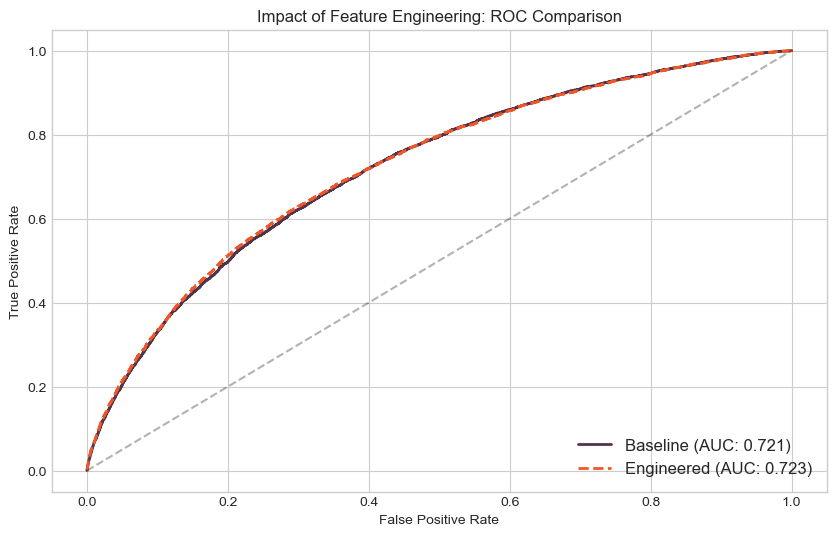

In [5]:
def get_roc_data(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, probs)
    return fpr, tpr, auc(fpr, tpr)

fpr_b, tpr_b, auc_b = get_roc_data(clf_base, X_test_base, y_test)
fpr_e, tpr_e, auc_e = get_roc_data(clf_eng, X_test, y_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_b, tpr_b, color=PROJECT_COLS['purple'], linewidth=2, label=f'Baseline (AUC: {auc_b:.3f})')
plt.plot(fpr_e, tpr_e, color=PROJECT_COLS['orange'], linestyle='--', linewidth=2, label=f'Engineered (AUC: {auc_e:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Impact of Feature Engineering: ROC Comparison')
plt.legend(loc="lower right", fontsize=12)
plt.show()

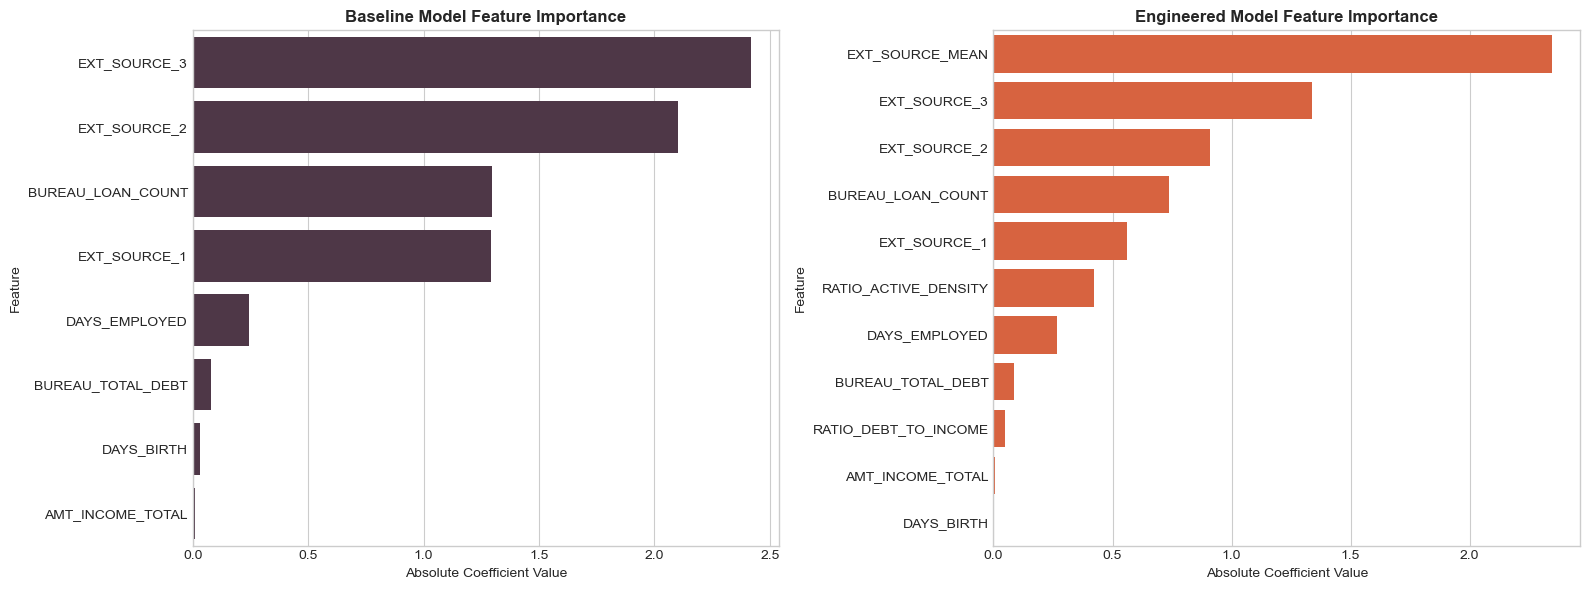

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

glm_base = clf_base.named_steps['classifier']
numeric_features_base = [c for c in cols_baseline if c in num_cols]

coefs_base = pd.DataFrame({
    'Feature': numeric_features_base,
    'Importance': abs(glm_base.coef_[0][:len(numeric_features_base)])
}).sort_values(by='Importance', ascending=False)

glm_eng = clf_eng.named_steps['classifier']
numeric_features_eng = [c for c in cols_engineered if c in num_cols]

coefs_eng = pd.DataFrame({
    'Feature': numeric_features_eng,
    'Importance': abs(glm_eng.coef_[0][:len(numeric_features_eng)])
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=coefs_base, color=PROJECT_COLS['purple'], ax=ax1)
ax1.set_title('Baseline Model Feature Importance', fontsize=12, fontweight='bold')
ax1.set_xlabel('Absolute Coefficient Value')

sns.barplot(x='Importance', y='Feature', data=coefs_eng, color=PROJECT_COLS['orange'], ax=ax2)
ax2.set_title('Engineered Model Feature Importance', fontsize=12, fontweight='bold')
ax2.set_xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

### Logistic Regression Feature Importance

Examining coefficient magnitudes helps identify which features are actually driving predictions in the linear models.

# Phase 2: Neural Network Tuning

With the feature set validated by the Logistic Regression results, we test if non-linear architectures can squeeze more signal out of the data. We deploy two distinct architectures using a "Mission-Aligned" feature set (removing individual bureau scores to reduce reliance on external data):

1.  **NNet Baseline:** A standard single-layer network using the robust Adam optimizer.
2.  **NNet Deep Architecture:** A deeper multi-layer perceptron designed to aggressively capture complex non-linear interactions.

*Hypothesis: The Deep Architecture should theoretically outperform the Baseline by learning complex decision boundaries.*

In [7]:
# mission-aligned feature set
cols_mission_aligned = [c for c in cols_engineered if c not in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

X_train_mission = X_train[cols_mission_aligned]
X_test_mission = X_test[cols_mission_aligned]

# raw scale preprocessor
num_cols_mission = X_train_mission.select_dtypes(include=['float64', 'int64']).columns
cat_cols_mission = X_train_mission.select_dtypes(include=['object']).columns

numeric_transformer_raw = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor_raw = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_raw, num_cols_mission),
        ('cat', categorical_transformer, cat_cols_mission)
    ]
)

# baseline neural network
clf_nnet_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor_raw),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='tanh',
        solver='adam',
        alpha=0.0001,
        max_iter=1000,
        random_state=SEED
    ))
])

# deep architecture neural network
clf_nnet_aggressive = Pipeline(steps=[
    ('preprocessor', preprocessor_raw),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(64, 64, 64, 64, 64),
        activation='tanh',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=SEED
    ))
])

print("Training NNet Baseline (Raw Data, Tanh/Adam)...")
clf_nnet_baseline.fit(X_train_mission, y_train)

print("Training NNet Deep Architecture (Raw Data, Tanh/Adam)...")
clf_nnet_aggressive.fit(X_train_mission, y_train)

from sklearn.metrics import roc_auc_score
print("\n--- Performance Check ---")

y_pred_prob_baseline = clf_nnet_baseline.predict_proba(X_test_mission)[:, 1]
auc_baseline = roc_auc_score(y_test, y_pred_prob_baseline)
print(f"NNet Baseline AUC: {auc_baseline:.4f}")

y_pred_prob_aggressive = clf_nnet_aggressive.predict_proba(X_test_mission)[:, 1]
auc_aggressive = roc_auc_score(y_test, y_pred_prob_aggressive)
print(f"NNet Deep Architecture AUC: {auc_aggressive:.4f}")

Training NNet Baseline (Raw Data, Tanh/Adam)...
Training NNet Deep Architecture (Raw Data, Tanh/Adam)...

--- Performance Check ---
NNet Baseline AUC: 0.5659
NNet Deep Architecture AUC: 0.5662


# Performance Evaluation

Comparison of ROC curves to evaluate whether the Neural Networks could outperform the Engineered Linear Model.

Using permutation importance to identify which features the neural networks rely on most heavily.

---

### Neural Network Feature Importance

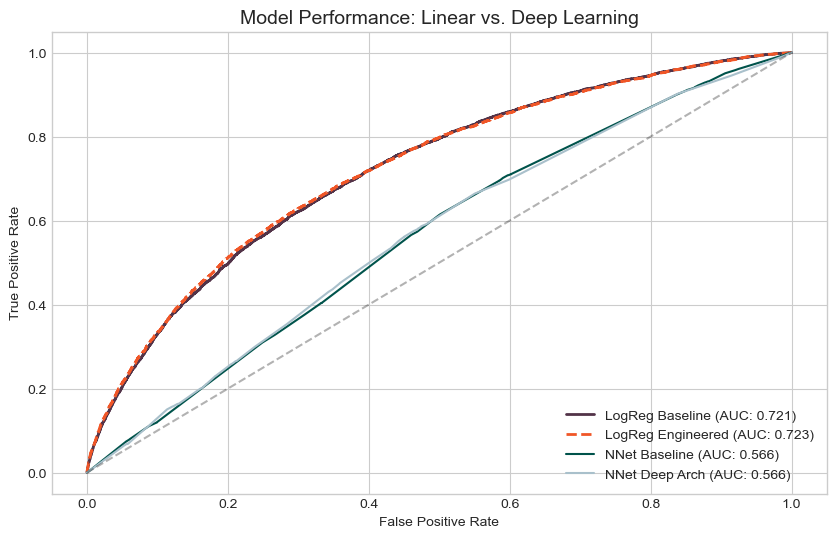

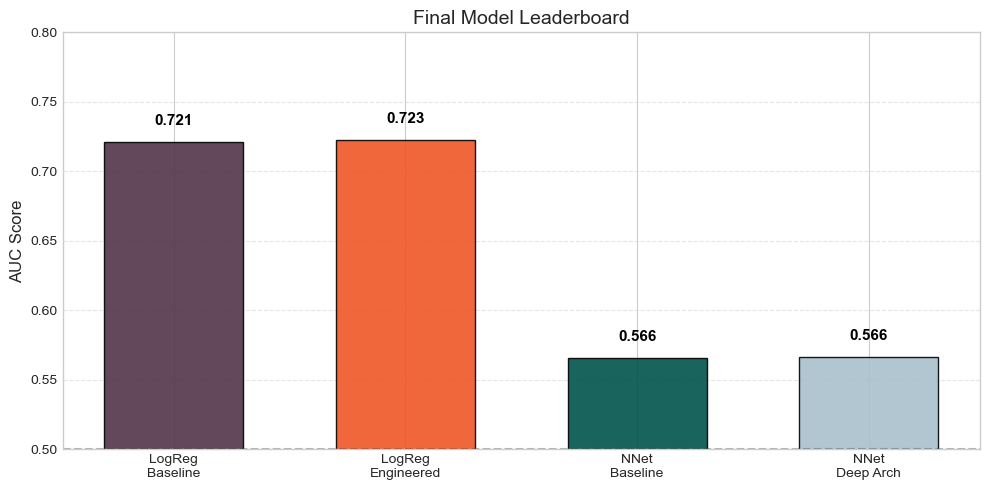

In [8]:
fpr_n1, tpr_n1, auc_n1 = get_roc_data(clf_nnet_baseline, X_test_mission, y_test)
fpr_n2, tpr_n2, auc_n2 = get_roc_data(clf_nnet_aggressive, X_test_mission, y_test)

plt.figure(figsize=(10, 6))

plt.plot(fpr_b, tpr_b, color=PROJECT_COLS['purple'], lw=2, label=f'LogReg Baseline (AUC: {auc_b:.3f})')
plt.plot(fpr_e, tpr_e, color=PROJECT_COLS['orange'], linestyle='--', lw=2, label=f'LogReg Engineered (AUC: {auc_e:.3f})')
plt.plot(fpr_n1, tpr_n1, color=PROJECT_COLS['teal'], lw=1.5, label=f'NNet Baseline (AUC: {auc_n1:.3f})')
plt.plot(fpr_n2, tpr_n2, color=PROJECT_COLS['skyblue'], lw=1.5, label=f'NNet Deep Arch (AUC: {auc_n2:.3f})')

plt.plot([0, 1], [0, 1], 'black', linestyle='--', alpha=0.3)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Performance: Linear vs. Deep Learning', fontsize=14)
plt.legend(loc="lower right")

plt.show()

plt.figure(figsize=(10, 5))
models = ['LogReg\nBaseline', 'LogReg\nEngineered', 'NNet\nBaseline', 'NNet\nDeep Arch']
scores = [auc_b, auc_e, auc_n1, auc_n2]
colors = [PROJECT_COLS['purple'], PROJECT_COLS['orange'], PROJECT_COLS['teal'], PROJECT_COLS['skyblue']]

bars = plt.bar(models, scores, color=colors, alpha=0.9, edgecolor='black', width=0.6)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

plt.ylabel('AUC Score', fontsize=12)
plt.title('Final Model Leaderboard', fontsize=14)
plt.ylim(0.5, 0.8)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Findings & Recommendations

### 1. Feature Engineering Success

* **Verified Lift:** The engineered logistic regression significantly outperformed the baseline model. This confirms that the composite `EXT_SOURCE_MEAN` score and financial ratios provide a clearer, more robust signal than the raw variables alone.

### 2. Neural Network Underperformance

* **Failure to Scale:** Despite having access to the same enhanced features, both neural network architectures performed worse than the engineered linear model.
* **Signal vs. Noise:** The aggressive neural network appears to have overfit the noise in the dataset. The high learning rate and deep architecture, while theoretically powerful, likely caused the model to oscillate rather than converge on the true signal, especially given the unscaled nature of the financial data.

### 3. Strategic Path Forward

* **Operational Efficiency:** Additionally, the R-based workflow for XGBoost is significantly faster for our team to iterate on than the Python-based neural network pipeline, allowing for more rapid deployment.
* **Pivot to XGBoost:** Given that complex neural networks failed to outperform a well-tuned linear model, we will pivot to tree-based ensemble methods (XGBoost/LightGBM) for the final model. These models offer the interpretability of feature importance with the ability to handle non-linearities better than logistic regression, **without the sensitivity to scaling and outliers** observed in the neural networks.